In [24]:
import pandas as pd
import numpy as np
import os
import glob
import gc

# ==========================================
# 1. Config & Setup
# ==========================================
PROJECT_ROOT = os.path.dirname(os.getcwd())
RAW_DIR = os.path.join(PROJECT_ROOT, "data", "raw_full")
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)

# 缺失率阈值 (0.5 = 50%)
MISSING_THRESHOLD = 0.5 

# [CRITICAL] 强制保留名单 (PhenoAge 核心变量)
# 即使缺失率高 (如 LBXGLU ~50% missing)，也必须保留列
PHENOAGE_VARS = [
    "RIDAGEYR", # Age
    "LBXSAL",   # Albumin
    "LBXSCR",   # Creatinine
    "LBXGLU",   # Glucose (Fasting)
    "LBXHSCRP", # HS-CRP (Often renamed to LBXCRP in some cycles, check logic later)
    "LBXLYPCT", # Lymphocyte %
    "LBXMCVSI", # MCV
    "LBXRDW",   # RDW
    "LBXSAPSI", # Alkaline Phosphatase
    "LBXWBCSI"  # WBC
]

# Helper Function: Reduce Memory Usage
def optimize_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

print(f"📂 Reading from: {RAW_DIR}")

# ==========================================
# 2. Load Anchor (DEMO)
# ==========================================
all_files = glob.glob(os.path.join(RAW_DIR, "*.xpt")) + glob.glob(os.path.join(RAW_DIR, "*.XPT"))
all_files.sort()

demo_path = next((f for f in all_files if "DEMO" in os.path.basename(f).upper()), None)
if not demo_path: raise FileNotFoundError("CRITICAL: DEMO file not found!")

print(f"⚓ Anchor File: {os.path.basename(demo_path)}")
df_master = pd.read_sas(demo_path)
df_master['SEQN'] = df_master['SEQN'].astype('int32')

# Filter for Adults Only (Age >= 20)
if 'RIDAGEYR' in df_master.columns:
    initial_count = len(df_master)
    df_master = df_master[df_master['RIDAGEYR'] >= 20]
    print(f"📉 Filtered Age >= 20: Dropped {initial_count - len(df_master)} participants (Children/Teens).")
else:
    print("⚠️ WARNING: RIDAGEYR not found! Keeping all ages.")

base_seqns = set(df_master['SEQN'])
print(f"   Anchor Shape: {df_master.shape}")

# ==========================================
# 3. Iterative Merge (with Force Keep)
# ==========================================
print("\n🚀 Starting SAFE iterative merge...")
count = 0
dropped_vars_count = 0

for f in all_files:
    if f == demo_path: continue
    gc.collect()
    
    try:
        # A. Read
        df_temp = pd.read_sas(f)
        
        # B. Check Key
        if 'SEQN' not in df_temp.columns:
            del df_temp; continue
        df_temp['SEQN'] = df_temp['SEQN'].astype('int32')
        
        # C. Dedup Rows
        if df_temp['SEQN'].duplicated().any():
            df_temp = df_temp.groupby('SEQN').first().reset_index()

        # D. Filter Rows (Match Anchor)
        df_temp = df_temp[df_temp['SEQN'].isin(base_seqns)]
        if df_temp.empty:
            del df_temp; continue

        # E. Filter Columns (Threshold + Force Keep)
        missing = df_temp.isnull().mean()
        valid_cols = missing[missing <= MISSING_THRESHOLD].index.tolist()
        
        # [FORCE KEEP LOGIC]
        for var in PHENOAGE_VARS:
            if var in df_temp.columns and var not in valid_cols:
                valid_cols.append(var)
                print(f"   🔥 Force keeping: {var} (Missing: {missing[var]:.1%})")
        
        # Stats
        dropped_vars_count += (len(missing) - len(valid_cols))
        
        # Apply Filter
        new_cols = [c for c in valid_cols if c not in df_master.columns or c == 'SEQN']
        if len(new_cols) <= 1:
            del df_temp; continue
            
        df_temp = df_temp[new_cols]
        df_temp = optimize_dtypes(df_temp)
        
        # F. Merge
        df_master = pd.merge(df_master, df_temp, on='SEQN', how='left')
        
        del df_temp
        count += 1
        if count % 10 == 0:
            print(f"   ... Merged {count} files. Current Shape: {df_master.shape}")
            
    except Exception as e:
        print(f"⚠️ Error {os.path.basename(f)}: {e}")

print(f"\n✅ Merge Complete. Shape: {df_master.shape}")
print(f"🗑️ Dropped {dropped_vars_count} high-missing variables.")

# ==========================================
# 4. Final Row Filtration (Complete Cases)
# ==========================================
print("\n🧹 Filtering for Complete PhenoAge Cases...")

# Check availability
existing_pheno = [c for c in PHENOAGE_VARS if c in df_master.columns]
if len(existing_pheno) < len(PHENOAGE_VARS):
    print(f"⚠️ Missing vars: {set(PHENOAGE_VARS) - set(existing_pheno)}")

# Drop rows with ANY missing PhenoAge value
rows_before = len(df_master)
df_clean = df_master.dropna(subset=existing_pheno)
rows_after = len(df_clean)

print(f"   Rows Before: {rows_before}")
print(f"   Rows After : {rows_after} (Complete Cases Only)")
print(f"   📉 Dropped {rows_before - rows_after} participants.")

# ==========================================
# 5. [NEW] Drop "Zombie" Columns (100% Empty)
# ==========================================
# 行筛选后，很多针对被删人群（如婴儿）的变量会变成全空，必须清理掉。
print("\n🧽 Removing columns that became empty after row filtration...")

cols_before = df_clean.shape[1]
# dropna(axis=1, how='all') 删除所有值都是 NaN 的列
df_clean = df_clean.dropna(axis=1, how='all')
cols_after = df_clean.shape[1]

print(f"   Cols Before: {cols_before}")
print(f"   Cols After : {cols_after}")
print(f"   🗑️ Removed {cols_before - cols_after} empty columns (e.g., child-only data).")

# ==========================================
# 6. Save
# ==========================================
save_path_pkl = os.path.join(PROCESSED_DIR, "nhanes_2017_2018_filtered.pkl")
save_path_csv = os.path.join(PROCESSED_DIR, "nhanes_2017_2018_filtered.csv")

print(f"\n💾 Saving to {save_path_pkl}...")
df_clean.to_pickle(save_path_pkl)
df_clean.to_csv(save_path_csv, index=False)

print(f"🎉 SUCCESS! Final Clean Dataset Shape: {df_clean.shape}")

📂 Reading from: /Users/qiunan/MAP_Hackathon_2026_G4/data/raw_full
⚓ Anchor File: DEMO_J.xpt
📉 Filtered Age >= 20: Dropped 3685 participants (Children/Teens).
   Anchor Shape: (5569, 46)

🚀 Starting SAFE iterative merge...
   ... Merged 10 files. Current Shape: (5569, 1164)
   ... Merged 20 files. Current Shape: (5569, 1275)
   ... Merged 30 files. Current Shape: (5569, 1664)
   ... Merged 40 files. Current Shape: (5569, 1858)
   ... Merged 50 files. Current Shape: (5569, 1921)
   ... Merged 60 files. Current Shape: (5569, 1941)
   ... Merged 70 files. Current Shape: (5569, 2041)
   ... Merged 80 files. Current Shape: (5569, 2307)
   ... Merged 90 files. Current Shape: (5569, 2431)
   ... Merged 100 files. Current Shape: (5569, 2512)
   ... Merged 110 files. Current Shape: (5569, 2578)
   ... Merged 120 files. Current Shape: (5569, 2799)

✅ Merge Complete. Shape: (5569, 2799)
🗑️ Dropped 1155 high-missing variables.

🧹 Filtering for Complete PhenoAge Cases...
   Rows Before: 5569
   Rows

Calculation Check:
 - Total Variables: 2799
 - Variables to Keep (<= 50%): 1168
 - Variables to Drop (> 50%): 1631


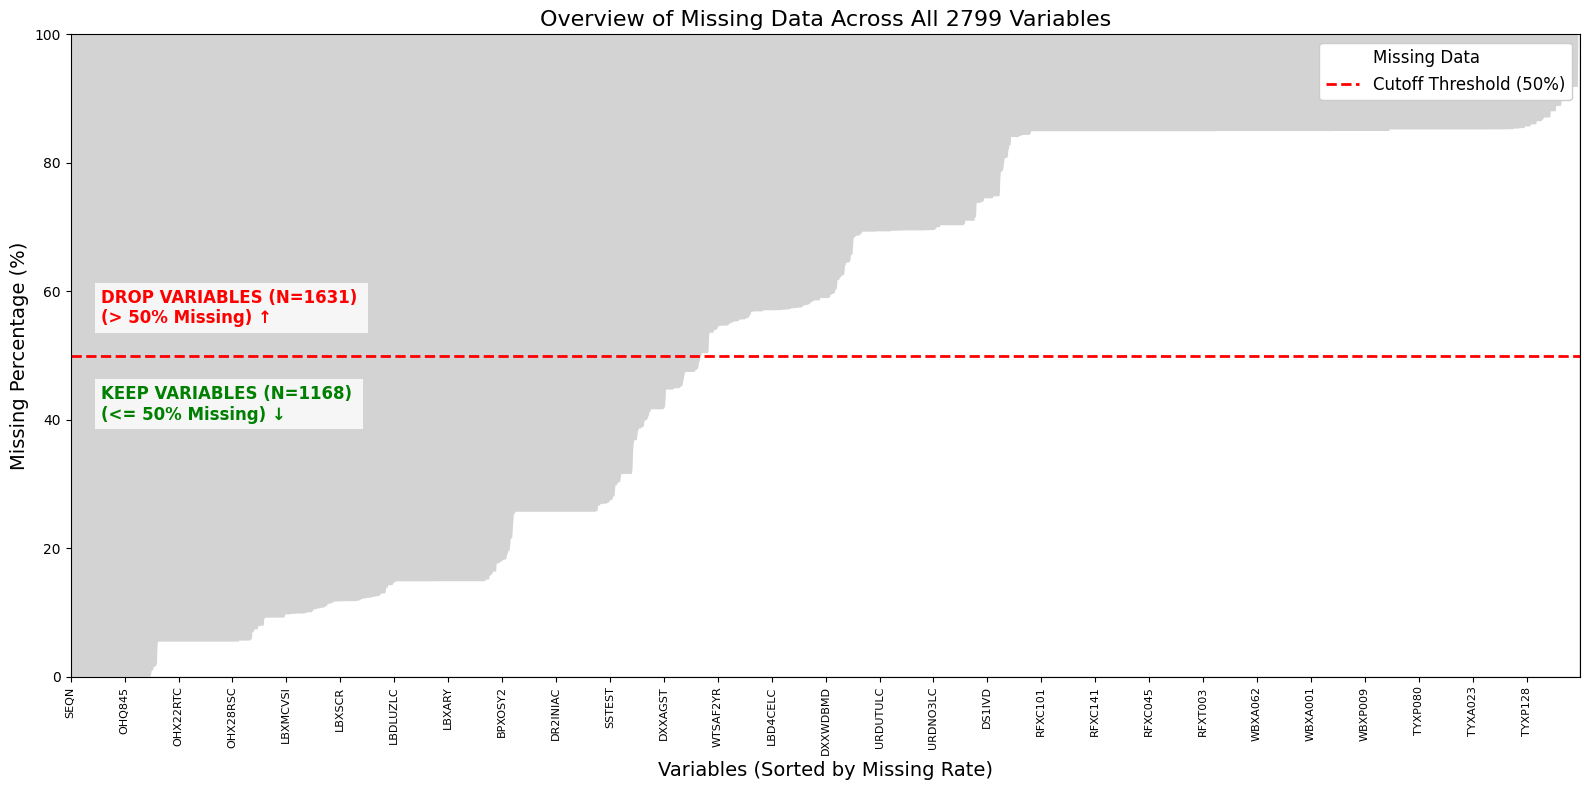

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# =============================================================
# Missing Data Overview (Variables on X-axis, Counts Included)
# =============================================================

# 1. Calculate missing rates for all variables (0-100%)
# Ensure we are using the full master dataframe before saving
all_missing = df_master.isnull().mean() * 100
all_missing_sorted = all_missing.sort_values(ascending=True)

# 2. Calculate the counts for annotations based on the threshold
THRESHOLD = 50  # 50%
n_keep = (all_missing_sorted <= THRESHOLD).sum()
n_drop = (all_missing_sorted > THRESHOLD).sum()

print(f"Calculation Check:")
print(f" - Total Variables: {len(all_missing_sorted)}")
print(f" - Variables to Keep (<= {THRESHOLD}%): {n_keep}")
print(f" - Variables to Drop (> {THRESHOLD}%): {n_drop}")

# 3. Initialize the plot
fig, ax = plt.subplots(figsize=(16, 8))
# Set background to gray (representing 'Present' data)
ax.set_facecolor('lightgray')

# X coordinates for each variable
x_pos = np.arange(len(all_missing_sorted))

# 4. Fill the area representing missing data
# This draws the white "missing" area on top of the gray "present" background
ax.fill_between(x_pos, 0, all_missing_sorted.values, color='white', edgecolor='none', label='Missing Data')

# 5. Add the Horizontal Cutoff Threshold (Red dashed line)
ax.axhline(y=THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Cutoff Threshold ({THRESHOLD}%)')

# 6. Configure Axis Limits
ax.set_xlim(0, len(all_missing_sorted))
ax.set_ylim(0, 100)

# 7. Labels and Title
ax.set_ylabel('Missing Percentage (%)', fontsize=14)
ax.set_xlabel('Variables (Sorted by Missing Rate)', fontsize=14)
ax.set_title(f'Overview of Missing Data Across All {len(all_missing_sorted)} Variables', fontsize=16)

# 8. X-axis Tick Management 
# Since there are 2000+ columns, showing all names is impossible. 
# We show every 100th column name to keep it legible.
step = 100
ax.set_xticks(np.arange(0, len(all_missing_sorted), step))
ax.set_xticklabels(all_missing_sorted.index[::step], rotation=90, fontsize=8)

# 9. Smart Annotations 
# Position text relative to the data size and threshold
text_x_pos = len(all_missing_sorted) * 0.02 # Slightly offset from left

# Label for Dropped Variables (Above line)
ax.text(text_x_pos, THRESHOLD + 5, 
        f'DROP VARIABLES (N={n_drop}) \n(> {THRESHOLD}% Missing) ↑', 
        color='red', fontsize=12, fontweight='bold', 
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Label for Kept Variables (Below line)
ax.text(text_x_pos, THRESHOLD - 10, 
        f'KEEP VARIABLES (N={n_keep}) \n(<= {THRESHOLD}% Missing) ↓', 
        color='green', fontsize=12, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# 10. Legend
ax.legend(loc='upper right', fontsize=12, frameon=True, facecolor='white', framealpha=1)

plt.tight_layout()
plt.show()

## Imports & Setup

In [9]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Config
PROJECT_ROOT = os.path.dirname(os.getcwd())
RAW_DIR = os.path.join(PROJECT_ROOT, "data", "raw_full")
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Threshold: Drop columns with > 50% missing values
MISSING_THRESHOLD = 0.5 

# Helper Function: Reduce Memory Usage 
def optimize_dtypes(df):
    """
    Converts float64 -> float32 and int64 -> int32 to save memory.
    """
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')
            
    return df

print(f"📂 Reading from: {RAW_DIR}")
print(f"🎯 Saving to: {PROCESSED_DIR}")

📂 Reading from: /Users/qiunan/MAP_Hackathon_2026_G4/data/raw_full
🎯 Saving to: /Users/qiunan/MAP_Hackathon_2026_G4/data/processed


## Load All Data

In [13]:
# 1. Get all file paths
all_files = glob.glob(os.path.join(RAW_DIR, "*.xpt")) + glob.glob(os.path.join(RAW_DIR, "*.XPT"))
demo_path = next((f for f in all_files if "DEMO" in os.path.basename(f).upper()), None)

if not demo_path:
    raise FileNotFoundError("CRITICAL: DEMO file not found!")

print(f"⚓ Anchor File: {os.path.basename(demo_path)}")
df_master = pd.read_sas(demo_path)

# Optimize Anchor immediately
df_master['SEQN'] = df_master['SEQN'].astype('int32')
df_master = optimize_dtypes(df_master)


#  Filter for Adults Only (Age >= 20) for PhenoAge
# RIDAGEYR is the variable for Age in years at screening
if 'RIDAGEYR' in df_master.columns:
    initial_count = len(df_master)
    df_master = df_master[df_master['RIDAGEYR'] >= 20]
    print(f" Filtered Age >= 20: Dropped {initial_count - len(df_master)} participants (Children/Teens).")
    print(f"   New Anchor Shape: {df_master.shape}")
else:
    print("⚠️ WARNING: RIDAGEYR (Age) not found in DEMO file! Skipping age filter.")

# Update the set of valid IDs so we only merge data for these adults
base_seqns = set(df_master['SEQN'])


print(f"   Initial Shape: {df_master.shape}")
print(f"   Memory (Optimized): {df_master.memory_usage().sum() / 1024**2:.2f} MB")
print(f"   Initial Shape: {df_master.shape} (among 9254 rows)")

⚓ Anchor File: DEMO_J.xpt
 Filtered Age >= 20: Dropped 3685 participants (Children/Teens).
   New Anchor Shape: (5569, 46)
   Initial Shape: (5569, 46)
   Memory (Optimized): 1.02 MB
   Initial Shape: (5569, 46) (among 9254 rows)


## Memory-Optimized Iterative Merge

In [ ]:

count = 0
all_files.sort() # Sort for predictable merging order

print("🚀 Starting SAFE iterative merge with deduplication...")

for f in all_files:
    if f == demo_path: continue
    
    # Run Garbage Collection to clear memory spikes from previous loops
    gc.collect()
    
    try:
        # A. Read file
        df_temp = pd.read_sas(f)
        
        # B. Check for Primary Key
        if 'SEQN' not in df_temp.columns:
            del df_temp
            continue
            
        df_temp['SEQN'] = df_temp['SEQN'].astype('int32')
        
        # C. [CRITICAL] Row Deduplication
        # Collapse multiple rows per user (e.g. meds, diet) into a single row.
        # This prevents the exponential row growth that crashes the kernel.
        if df_temp['SEQN'].duplicated().any():
            df_temp = df_temp.groupby('SEQN').first().reset_index()

        # D. Filter Rows (Keep only participants present in DEMO)
        df_temp = df_temp[df_temp['SEQN'].isin(base_seqns)]
        
        if df_temp.empty:
            del df_temp
            continue

        # E. Filter Columns (Based on missingness and duplicates)
        # Calculate missing rate only on the participants we actually kept
        missing = df_temp.isnull().mean()
        valid_cols = missing[missing <= MISSING_THRESHOLD].index.tolist()
        
        # Only keep columns not already in our master table (except the key)
        new_cols = [c for c in valid_cols if c not in df_master.columns or c == 'SEQN']
        
        if len(new_cols) <= 1: # Only SEQN remains
            del df_temp
            continue
            
        df_temp = df_temp[new_cols]
        df_temp = optimize_dtypes(df_temp)
        
        # F. Merge (Left Join ensures row count stays constant at ~9254)
        df_master = pd.merge(df_master, df_temp, on='SEQN', how='left')
        
        del df_temp
        count += 1
        
        if count % 10 == 0:
            mem_usage = df_master.memory_usage().sum() / 1024**2
            print(f"   ... Merged {count} files. Shape: {df_master.shape}, Mem: {mem_usage:.2f} MB")
            
    except Exception as e:
        print(f"⚠️ Error processing {os.path.basename(f)}: {e}")
        gc.collect()

🚀 Starting SAFE iterative merge with deduplication...
   ... Merged 10 files. Shape: (5569, 1164), Mem: 24.77 MB
   ... Merged 20 files. Shape: (5569, 1275), Mem: 27.15 MB
   ... Merged 30 files. Shape: (5569, 1664), Mem: 35.44 MB
   ... Merged 40 files. Shape: (5569, 1858), Mem: 39.56 MB
   ... Merged 50 files. Shape: (5569, 1921), Mem: 40.89 MB
   ... Merged 60 files. Shape: (5569, 1941), Mem: 41.32 MB
   ... Merged 70 files. Shape: (5569, 2041), Mem: 43.49 MB
   ... Merged 80 files. Shape: (5569, 2307), Mem: 51.90 MB
   ... Merged 90 files. Shape: (5569, 2431), Mem: 54.79 MB
   ... Merged 100 files. Shape: (5569, 2512), Mem: 56.55 MB
   ... Merged 110 files. Shape: (5569, 2578), Mem: 57.95 MB
   ... Merged 120 files. Shape: (5569, 2799), Mem: 62.65 MB


## Filter by Missing Values & Save

In [15]:
print("🧹 Starting Filtration...")

# 1. Calculate missing rates
missing_series = df_master.isnull().mean()

# 2. Identify keep vs drop
keep_cols = missing_series[missing_series <= MISSING_THRESHOLD].index
drop_cols = missing_series[missing_series > MISSING_THRESHOLD].index

print(f"   Total Variables: {len(missing_series)}")
print(f"   Keep (<= {MISSING_THRESHOLD*100}% missing): {len(keep_cols)}")
print(f"   Drop (> {MISSING_THRESHOLD*100}% missing): {len(drop_cols)}")

# 3. Create filtered DataFrame
df_clean = df_master[keep_cols].copy()

# 4. Save
save_path = os.path.join(PROCESSED_DIR, "nhanes_2017_2018_filtered.csv")
# Use pickle for faster IO in Python, or CSV for compatibility
df_clean.to_csv(save_path, index=False)
df_clean.to_pickle(os.path.join(PROCESSED_DIR, "nhanes_2017_2018_filtered.pkl"))

print(f"\n🎉 Saved clean data to: {save_path}")
print(f"📊 Final Clean Shape: {df_clean.shape}")

🧹 Starting Filtration...
   Total Variables: 2799
   Keep (<= 50.0% missing): 1168
   Drop (> 50.0% missing): 1631

🎉 Saved clean data to: /Users/qiunan/MAP_Hackathon_2026_G4/data/processed/nhanes_2017_2018_filtered.csv
📊 Final Clean Shape: (5569, 1168)


## Visualize Missing Data

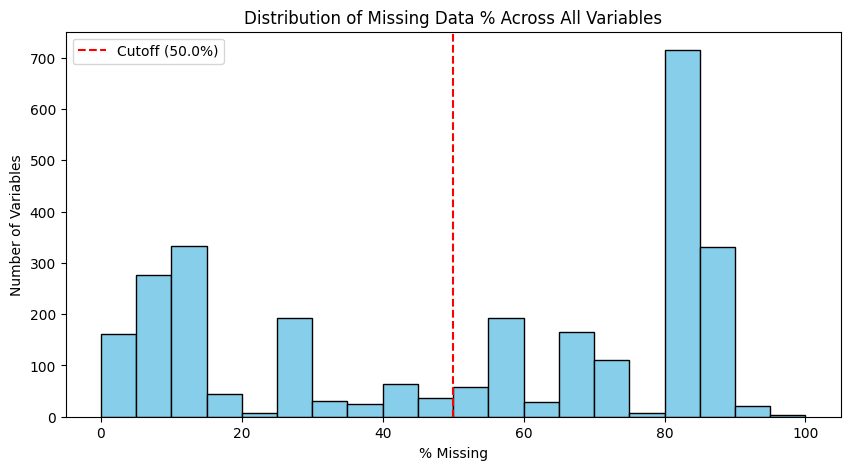

In [21]:
# see what we kept vs dropped
plt.figure(figsize=(10, 5))
plt.hist(missing_series * 100, bins=20, color='skyblue', edgecolor='black')
plt.axvline(MISSING_THRESHOLD * 100, color='red', linestyle='--', label=f'Cutoff ({MISSING_THRESHOLD*100}%)')
plt.title('Distribution of Missing Data % Across All Variables')
plt.xlabel('% Missing')
plt.ylabel('Number of Variables')
plt.legend()
plt.show()

## Missing Data Distribution (All Variables with Threshold Line)

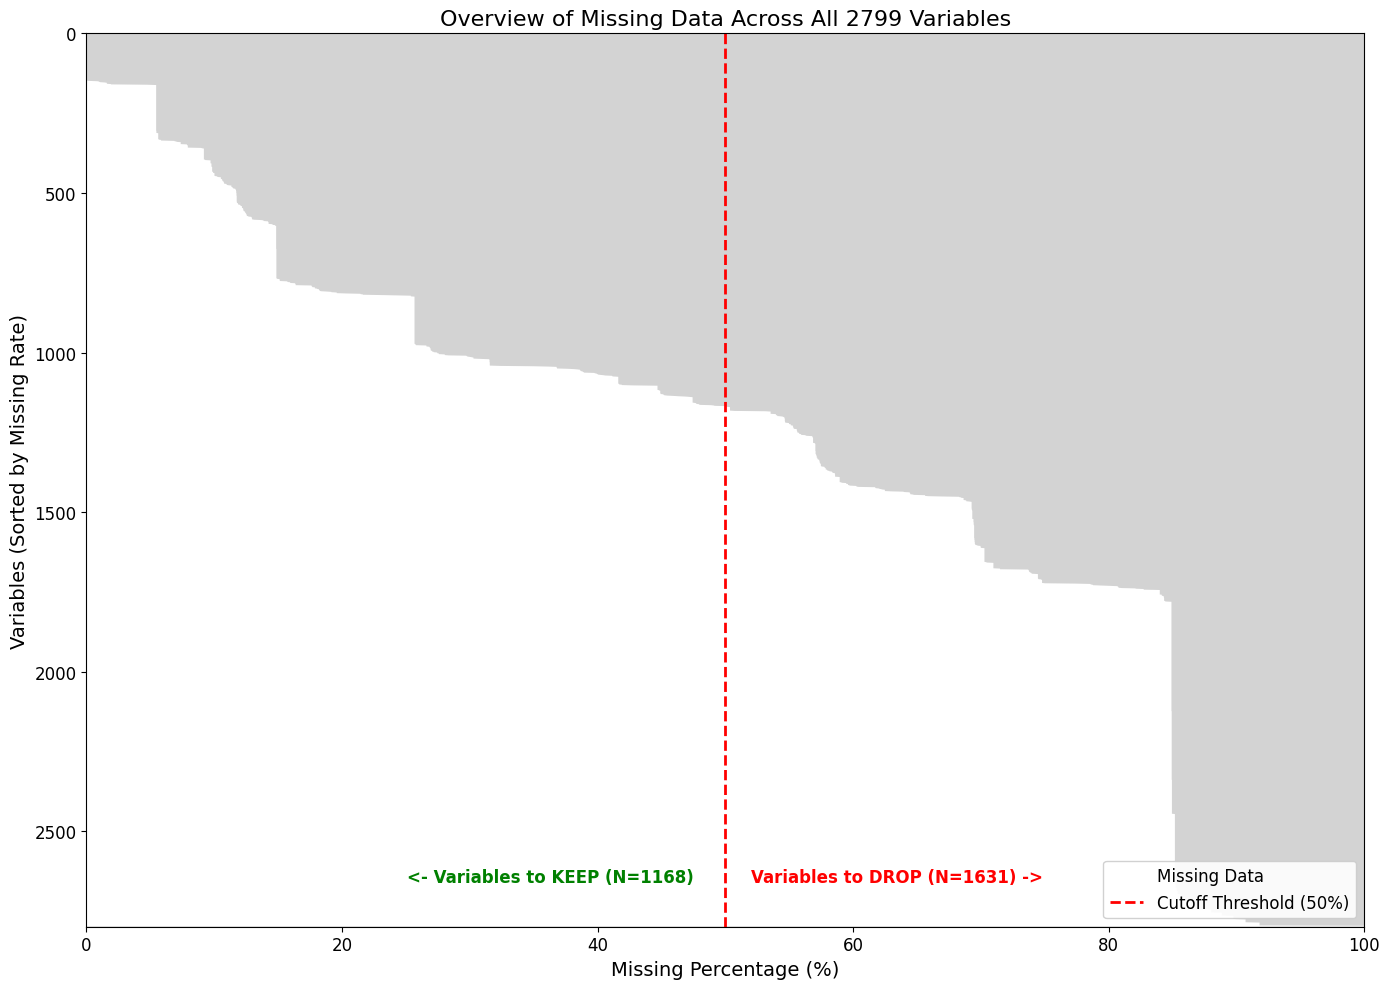

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==========================================
# Missing Data Distribution (All Variables with Threshold Line)
# ==========================================

# 1. Calculate missing rates for all variables (0-100%)
# df_master refers to your final merged master table
all_missing = df_master.isnull().mean() * 100
all_missing_sorted = all_missing.sort_values(ascending=True)
# Calculate the counts for annotations
THRESHOLD = 50
n_keep = (all_missing_sorted <= THRESHOLD).sum()
n_drop = (all_missing_sorted > THRESHOLD).sum()

# 2. Set up the figure/canvas
fig, ax = plt.subplots(figsize=(14, 10))

# 3. Draw an area plot (faster and cleaner than individual bars for 2000+ variables)
# White represents missing data; gray represents present data.
# For the best visual effect, we set the background to gray (present) 
# and overlay the white area (missing).
ax.set_facecolor('lightgray')

# Create Y-axis coordinates (from 0 to the total number of variables)
y_pos = np.arange(len(all_missing_sorted))

# Draw the white area: representing the portion of missing data
# fill_betweenx(y, x1, x2): fills the region between x1 and x2 along the y-axis
ax.fill_betweenx(y_pos, 0, all_missing_sorted.values, color='white', edgecolor='none', label='Missing Data')

# 4. Add the threshold line (Red dashed line)
# Draw a vertical line at the 50% mark
ax.axvline(x=THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Cutoff Threshold ({THRESHOLD}%)')

# 5. Configure coordinate axes
ax.set_xlim(0, 100)
ax.set_ylim(0, len(all_missing_sorted))
ax.invert_yaxis()  # Put high-quality variables (low missing rates) at the top

# 6. Set labels and title
ax.set_xlabel('Missing Percentage (%)', fontsize=14)
ax.set_ylabel('Variables (Sorted by Missing Rate)', fontsize=14)
ax.set_title(f'Overview of Missing Data Across All {len(all_missing_sorted)} Variables', fontsize=16)

# 7. Beautify ticks
# The Y-axis shows the count scale rather than specific names to avoid overlapping text
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Add Legend
ax.legend(loc='lower right', fontsize=12, frameon=True, facecolor='white', framealpha=0.9)

# Add Annotations
ax.text(THRESHOLD + 2, len(all_missing_sorted) * 0.95, 
        f'Variables to DROP (N={n_drop}) ->', 
        color='red', fontsize=12, fontweight='bold')
ax.text(THRESHOLD - 2, len(all_missing_sorted) * 0.95, 
        f'<- Variables to KEEP (N={n_keep}) ', 
        color='green', fontsize=12, fontweight='bold', ha='right')


plt.tight_layout()
plt.show()

## Variables List (< 10% Missing)

In [18]:
# 1. Calculate missing percentages
missing_stats = df_master.isnull().mean() * 100

# 2. Filter for variables with less than 10% missing values
low_missing = missing_stats[missing_stats < 10].sort_values()

# 3. Create a summary DataFrame
low_missing_df = pd.DataFrame({
    'Missing_Count': df_master[low_missing.index].isnull().sum(),
    'Missing_Percentage': low_missing.round(2)
})

# 4. Display the results
print(f"Number of variables with < 10% missing data: {len(low_missing_df)}")
print("\nFirst 30 variables with low missing rates:")
print(low_missing_df.head(20))

# Save this list for reference
low_missing_df.to_csv(os.path.join(PROCESSED_DIR, "low_missing_variables.csv"))

Number of variables with < 10% missing data: 438

First 30 variables with low missing rates:
         Missing_Count  Missing_Percentage
SEQN                 0                 0.0
MCQ160F              0                 0.0
MCQ160M              0                 0.0
MCQ160G              0                 0.0
MCQ160K              0                 0.0
MCQ160O              0                 0.0
MCQ160L              0                 0.0
MCQ520               0                 0.0
MCQ550               0                 0.0
MCQ560               0                 0.0
MCQ203               0                 0.0
MCQ220               0                 0.0
MCQ300B              0                 0.0
MCQ300C              0                 0.0
MCQ300A              0                 0.0
MCQ366A              0                 0.0
MCQ366B              0                 0.0
MCQ366C              0                 0.0
MCQ366D              0                 0.0
MCQ371A              0                 0.0
